In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split

from einops import rearrange, reduce, repeat
from utils.timer import Timer

# %matplotlib inline

In [2]:
device = 'cuda'

print(os.getcwd())
path_data_base = '../data/'
path_images = os.path.join(path_data_base, 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset')
path_img_train = os.path.join(path_images, 'train')
path_img_val = os.path.join(path_images, 'val')
path_img_test = os.path.join(path_images, 'test')

/home/bozidar/repos/pneumonia-xray/code


In [3]:
meta = pd.read_csv(os.path.join(path_data_base, 'Chest_xray_Corona_Metadata.csv'))
meta.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
train = meta[meta['Dataset_type'] == 'TRAIN'].copy().reset_index(drop=True)
test = meta[meta['Dataset_type'] == 'TEST'].copy().reset_index(drop=True)
n_train = len(train)
n_test = len(test)

train_name = train['X_ray_image_name']
train_label = train['Label']
test_name = test['X_ray_image_name']
test_label = test['Label']

print(f'{n_train=} {n_test=}')

n_train=5286 n_test=624


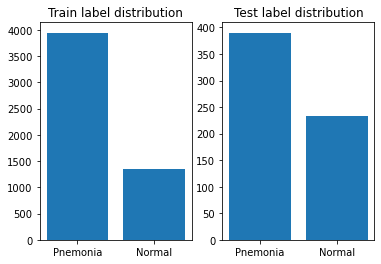

In [5]:
train_counts = train_label.value_counts()
test_counts = test_label.value_counts()

fig, ax = plt.subplots(1, 2)
ax[0].bar(train_counts.keys(), train_counts.values)
ax[1].bar(test_counts.keys(), test_counts.values)
ax[0].set_title('Train label distribution')
ax[1].set_title('Test label distribution')
fig.show()

In [6]:
# generate folder structure to use torchvision imageloader
def generate_data_folders(base_path, typ, img_paths, labels, split=None):
    # split - percentage of validation data
    l_unique = labels.unique()
    for l in l_unique:
        try:
            os.makedirs(os.path.join(base_path, typ, l))
            if split is not None:
                os.makedirs(os.path.join(base_path, 'val', l))
        except FileExistsError:
            # directory already exists
            pass

    for i in range(len(img_paths)):
        if (split is not None) and (np.random.rand() <= split):
            wr_path = os.path.join(base_path, 'val')
        else:
            wr_path = os.path.join(base_path, typ)

        shutil.move(os.path.join(base_path, typ, img_paths[i]), os.path.join(wr_path, labels[i], img_paths[i]))

# run the first time
# generate_data_folders(path_images, 'train', train_name, train_label, split=0.2)
# generate_data_folders(path_images, 'test', test_name, test_label)

In [7]:
img_h, img_w = 224, 224

inspect_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                   torchvision.transforms.ToTensor()])
inspect_data = torchvision.datasets.ImageFolder(path_img_train, transform=inspect_transform)
inspect_loader = DataLoader(inspect_data, batch_size=1, shuffle=True)

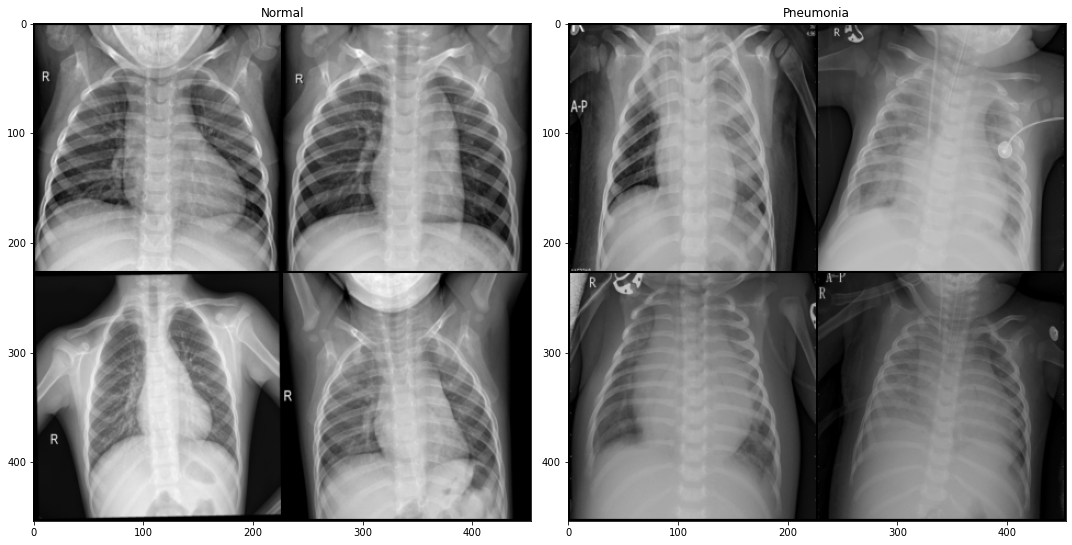

In [8]:
num = 4 # set even
cnt = [0, 0]
norm, pneum = [], [] 

for img, lbl in inspect_loader:
    if lbl == 1 and cnt[lbl] < num:
        pneum.append(img)
        cnt[lbl] += 1
    elif lbl == 0 and cnt[lbl] < num:
        norm.append(img)
        cnt[lbl] += 1
    elif cnt[0]+cnt[1] == 2*num:
        break
    
norm = torch.cat(norm, axis=0)
pneum = torch.cat(pneum, axis=0)
grid_norm = torchvision.utils.make_grid(norm, nrow=2)
grid_pneum = torchvision.utils.make_grid(pneum, nrow=2)

fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(rearrange(grid_norm, 'c h w -> h w c'))
ax[0].set_title('Normal')
ax[1].imshow(rearrange(grid_pneum, 'c h w -> h w c'))
ax[1].set_title('Pneumonia')
fig.show()
fig.tight_layout()

In [9]:
# only once to calculate values for normalization
# imgs = []
# inspect_loader = DataLoader(inspect_data, batch_size=128, shuffle=True)
# for img, _ in inspect_loader:
#     imgs.append(img)
#     i += 1
# ti = torch.cat(imgs, axis=0)

In [10]:
# means = torch.mean(ti, dim=(0,2,3))
# stds = torch.std(ti, dim=(0,2,3))
# print(f'{means=} {stds=}')

In [11]:
img_h, img_w = 224, 224

train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                                  torchvision.transforms.RandomVerticalFlip(p=0.1),
                                                  torchvision.transforms.RandomRotation(15),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

val_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

train_data = torchvision.datasets.ImageFolder(path_img_train, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_data = torchvision.datasets.ImageFolder(path_img_val, transform=val_transform)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_data = torchvision.datasets.ImageFolder(path_img_test, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [12]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


res18_tr = torchvision.models.resnet18(True)

In [13]:
# vggbn_tr.classifier
res18_tr

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# finetune only last
for param in res18_tr.parameters():
    param.requires_grad = False

res18_tr.fc = torch.nn.Linear(res18_tr.fc.in_features, 2)
net = res18_tr

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[8], gamma=0.1)

In [15]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
n_epochs = 5
train_loss = []
val_loss = []
train_acc = []
val_acc = []

net = net.to(device)
# net = net.double()


print(f'Successfully initialized.')

loss_epoch = 0.
acc_epoch = 0.
val_loss_epoch = 0.
val_acc_epoch = 0.


with Timer():
    net.train()
    t = tqdm(range(n_epochs))

    print(f'Optimization started!')

    for n_epoch in t:
        loss_epoch = 0.
        acc_epoch = 0.
        val_loss_epoch = 0.
        val_acc_epoch = 0.
        # n_batches = 0

        for batch_no, (data_batch, label_batch) in enumerate(train_loader):
            d = data_batch.to(device)
            # print(d.shape)

            l = label_batch.to(device)
            optim.zero_grad()
            pred = net(d)

            # print(pred.shape, l.shape)
            # break
            
            loss = loss_fn(pred, l)
            train_loss.append(loss.item())
            loss_epoch += loss.item()
            
            loss.backward()
            optim.step()

            cl = pred.argmax(axis=-1)
            acc = (cl == l).float().mean()
            acc_epoch += acc

            train_acc.append(acc)

            print(f'Batch {batch_no} Loss: {loss} Accuracy: {acc}')

            # n_batches += 1

        loss_epoch /= batch_no
        acc_epoch /= batch_no

        print(f'\tEpoch {n_epoch} Loss: {loss_epoch} Acc: {acc_epoch}')

        # net.eval()
        # for batch_no, (data_batch, label_batch) in enumerate(val_loader):
        #     d = data_batch.to(device)

        #     l = label_batch.to(device)
        #     pred = net(d)
            
        #     loss = loss_fn(pred, l)
        #     val_loss.append(loss.item())
        #     val_loss_epoch += loss.item()

        #     cl = pred.argmax(axis=-1)
        #     acc = (cl == l).float().mean()
        #     val_acc_epoch += acc

        #     val_acc.append(acc)

        #     print(f'[VAL] Batch {batch_no} Loss: {loss} Accuracy: {acc}')
        # net.train()

        # val_loss_epoch /= batch_no
        # val_acc_epoch /= batch_no

        # print(f'[VAL] Epoch {n_epoch} Loss: {val_loss_epoch} Acc: {val_acc_epoch}')

        scheduler.step()

  0%|          | 0/5 [00:00<?, ?it/s]Successfully initialized.
Optimization started!
Batch 0 Loss: 0.0119350366294384 Accuracy: 1.0
Batch 1 Loss: 0.012517750263214111 Accuracy: 1.0
Batch 2 Loss: 0.013338248245418072 Accuracy: 1.0
Batch 3 Loss: 0.029336560517549515 Accuracy: 1.0
Batch 4 Loss: 0.025322826579213142 Accuracy: 0.984375
Batch 5 Loss: 0.07798338681459427 Accuracy: 0.953125
Batch 6 Loss: 0.007383978925645351 Accuracy: 1.0
Batch 7 Loss: 0.0738842710852623 Accuracy: 0.96875
Batch 8 Loss: 0.029556354507803917 Accuracy: 0.984375
Batch 9 Loss: 0.019600704312324524 Accuracy: 1.0
Batch 10 Loss: 0.015429677441716194 Accuracy: 1.0
Batch 11 Loss: 0.014241330325603485 Accuracy: 1.0
Batch 12 Loss: 0.02492331527173519 Accuracy: 0.984375
Batch 13 Loss: 0.004364887718111277 Accuracy: 1.0
Batch 14 Loss: 0.03848908841609955 Accuracy: 0.96875
Batch 15 Loss: 0.02763941138982773 Accuracy: 0.984375
Batch 16 Loss: 0.018565300852060318 Accuracy: 1.0
Batch 17 Loss: 0.026132941246032715 Accuracy: 1.0


In [21]:
test_loss_epoch = 0.
test_acc_epoch = 0.

test_loss = []
test_acc = []

net.eval()
for batch_no, (data_batch, label_batch) in enumerate(test_loader):
    d = data_batch.to(device)

    l = label_batch.to(device)
    pred = net(d)
    
    loss = loss_fn(pred, l)
    test_loss.append(loss.item())
    test_loss_epoch += loss.item()

    cl = pred.argmax(axis=-1)
    acc = (cl == l).float().mean()
    test_acc_epoch += acc

    val_acc.append(acc)

    print(f'[TEST] Batch {batch_no} Loss: {loss} Accuracy: {acc}')

test_loss_epoch /= batch_no
test_acc_epoch /= batch_no

print(f'[TEST] Epoch {n_epoch} Loss: {test_loss_epoch} Acc: {test_acc_epoch}')

[TEST] Batch 0 Loss: 0.4665972888469696 Accuracy: 0.84375
[TEST] Batch 1 Loss: 0.7245891094207764 Accuracy: 0.84375
[TEST] Batch 2 Loss: 0.6925016045570374 Accuracy: 0.78125
[TEST] Batch 3 Loss: 0.6886029243469238 Accuracy: 0.90625
[TEST] Batch 4 Loss: 1.0215821266174316 Accuracy: 0.78125
[TEST] Batch 5 Loss: 0.8567652702331543 Accuracy: 0.84375
[TEST] Batch 6 Loss: 0.6865327954292297 Accuracy: 0.84375
[TEST] Batch 7 Loss: 0.6824137568473816 Accuracy: 0.875
[TEST] Batch 8 Loss: 1.534543752670288 Accuracy: 0.71875
[TEST] Batch 9 Loss: 0.6473404169082642 Accuracy: 0.84375
[TEST] Batch 10 Loss: 0.5959588885307312 Accuracy: 0.8125
[TEST] Batch 11 Loss: 1.177522897720337 Accuracy: 0.84375
[TEST] Batch 12 Loss: 1.310143232345581 Accuracy: 0.75
[TEST] Batch 13 Loss: 0.6881966590881348 Accuracy: 0.75
[TEST] Batch 14 Loss: 0.8673629760742188 Accuracy: 0.84375
[TEST] Batch 15 Loss: 0.8695189356803894 Accuracy: 0.875
[TEST] Batch 16 Loss: 1.2430484294891357 Accuracy: 0.8125
[TEST] Batch 17 Loss: 

In [ ]:
# plots (loss acc) - tensorboard, confusion matrix